# 08 - Billboard + Lyrics

In [12]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
#import seaborn as sns

from gensim.models import Word2Vec
from matplotlib import rcParams
from matplotlib.patches import Rectangle
from scipy.stats import relfreq
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from wordcloud import WordCloud

#sns.set(context='poster', style='white')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'arial'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

warnings.filterwarnings('ignore')

## Load data

In [13]:
df = pd.read_csv('../data/billboard-lyrics-spotify.csv')
df.sample(3)

,rank,song,artist_base,artist_all,year,artist_featured,song_clean,artist_clean,lyrics,acousticness,...,speechiness,tempo,time_signature,valence,duration_min,num_words,words_per_sec,num_uniq_words,decade,uniq_ratio
40,41,tiger,fabian forte,fabian,1959,NaN,tiger,fabian forte,NaN,0.749,...,0.0411,167.706,4.0,0.961,2.424017,NaN,NaN,NaN,1950,NaN
4757,81,here (in your arms),hellogoodbye,hellogoodbye,2007,NaN,here in your arms,hellogoodbye,i like where we are when we drive in your car ...,0.200,...,0.0360,126.053,4.0,0.803,4.009117,244.0,1.014355,48.0,2000,5.083333
1969,73,every kinda people,robert palmer,robert palmer,1978,NaN,every kinda people,robert palmer,said the fight to make ends meet keeps a man u...,0.228,...,0.0436,94.404,4.0,0.950,3.302450,202.0,1.019445,91.0,1970,2.219780


In [14]:
df_nonnull = df[df['lyrics'].notnull()]
lyrics = df_nonnull['lyrics']

## Verbosity over time

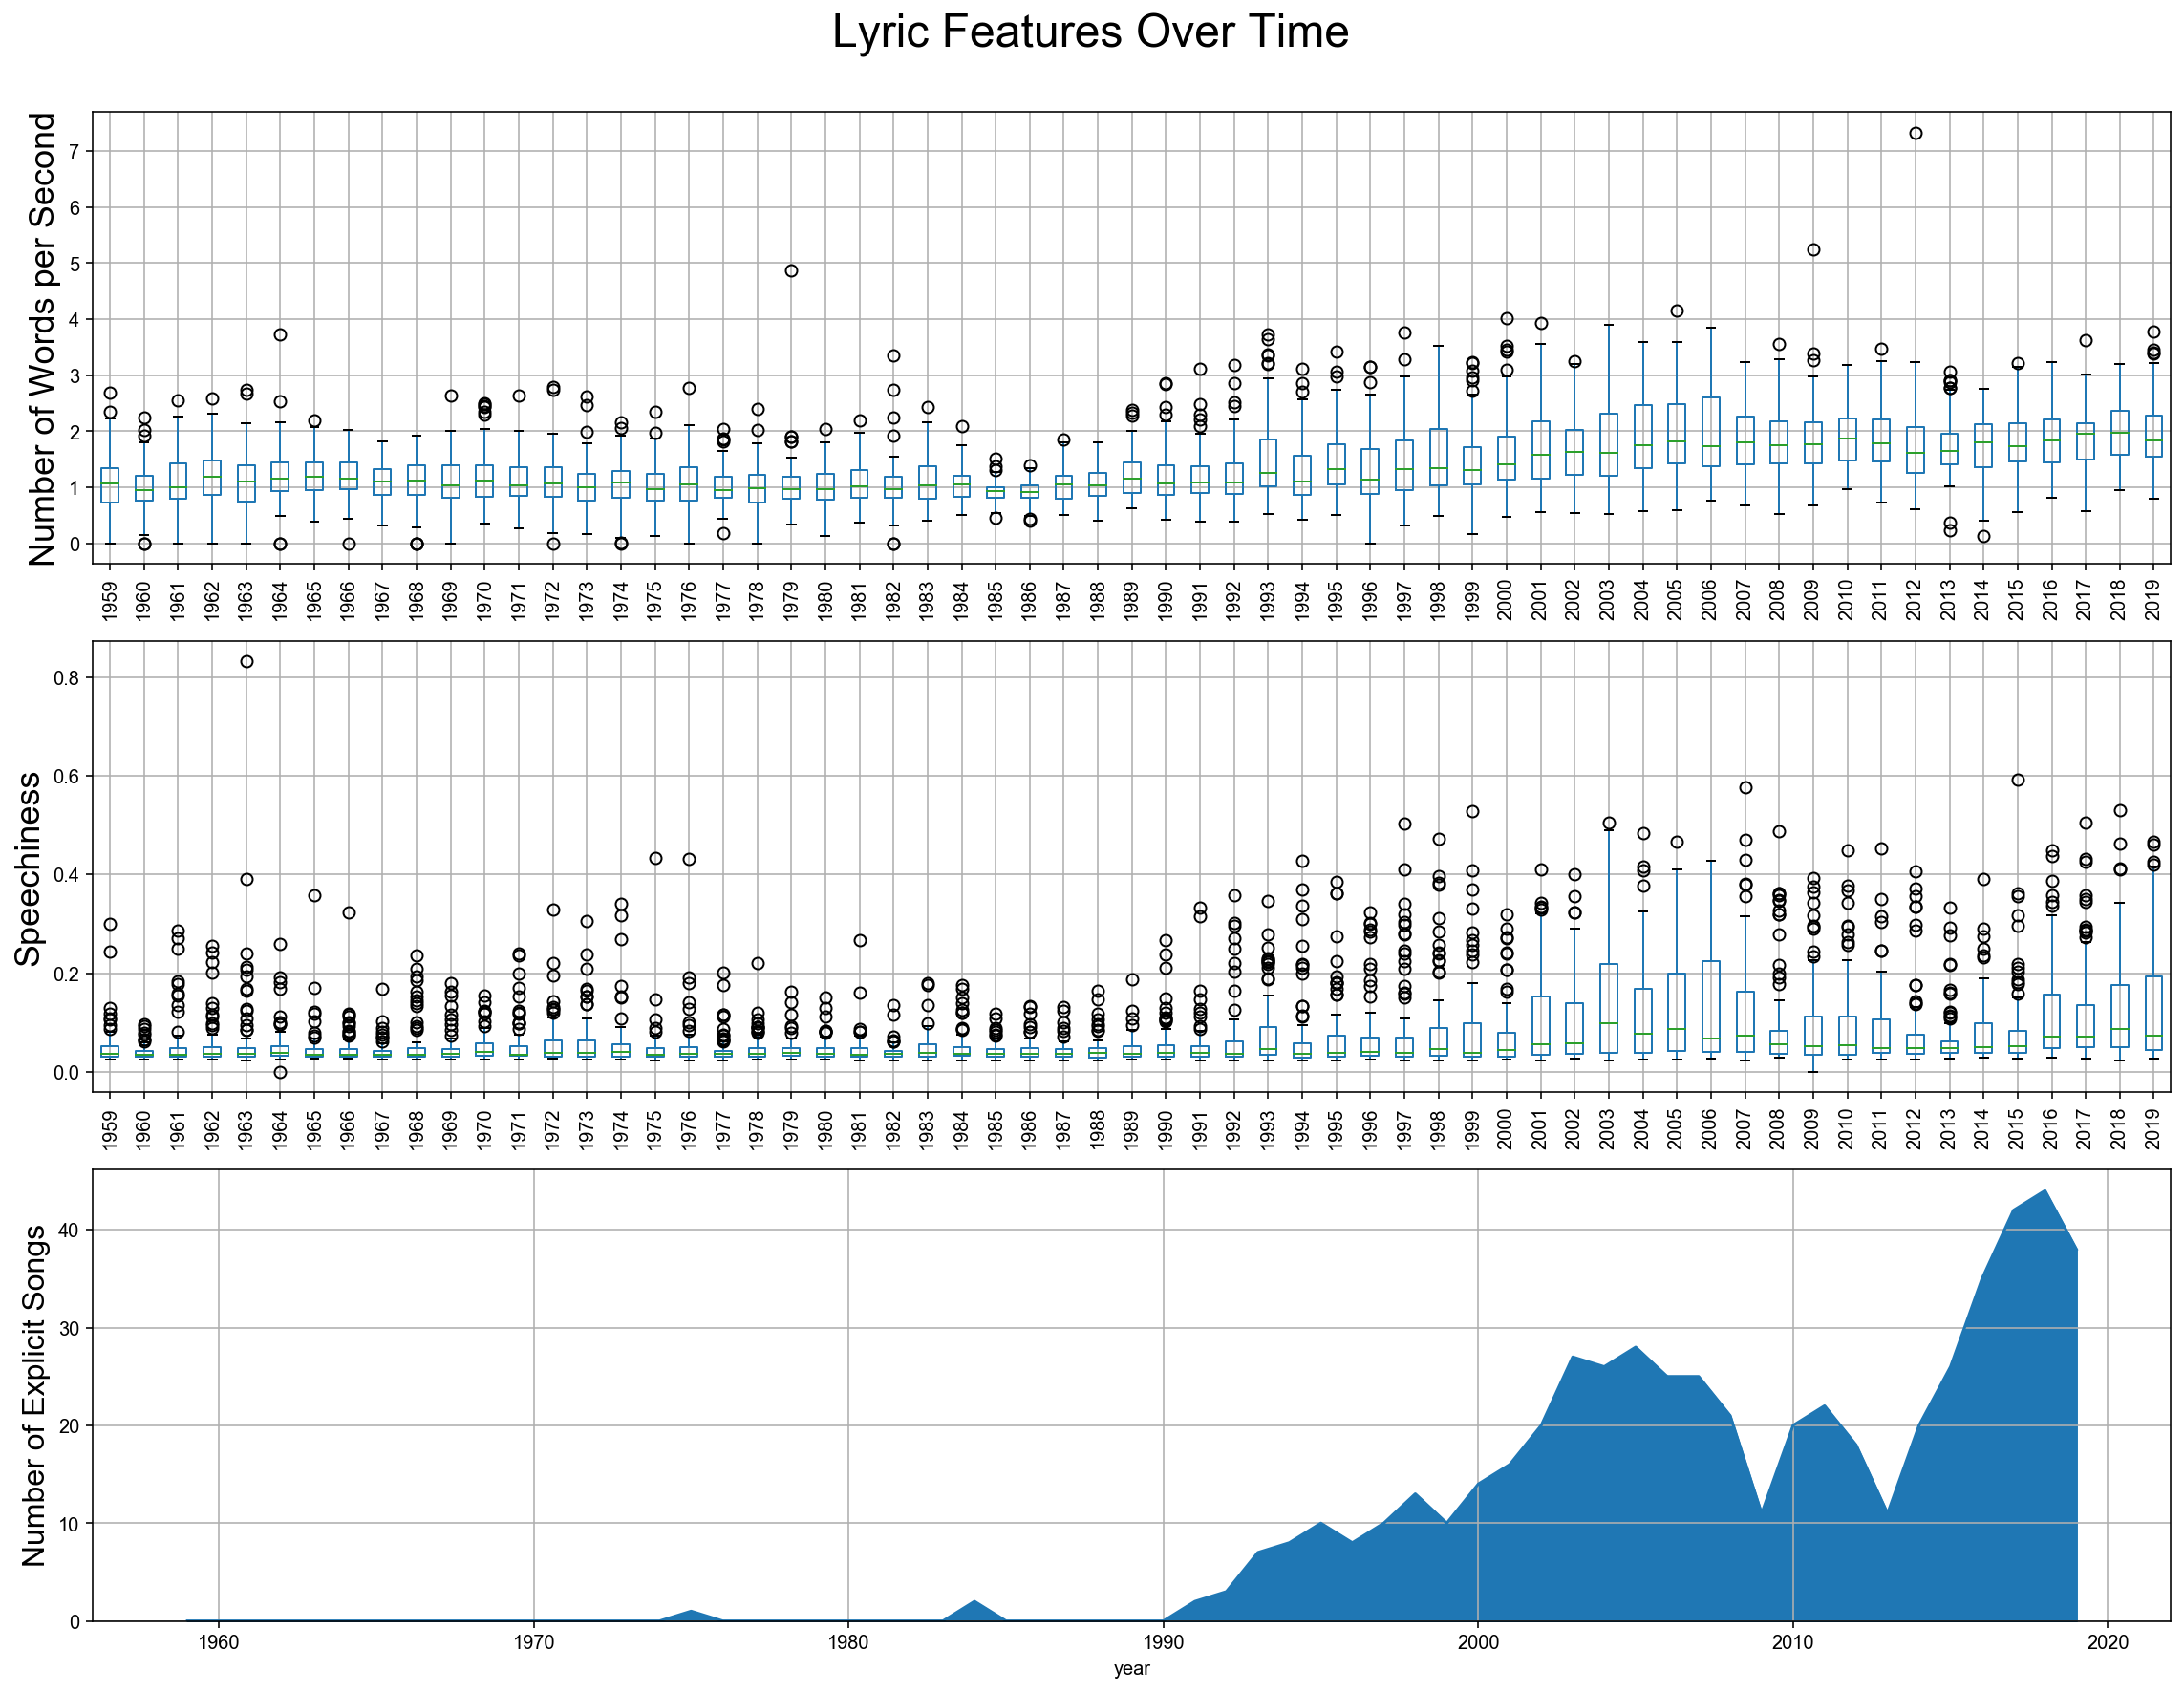

In [15]:
# make subplot axes
verbal_features = ['words_per_sec', 'speechiness']
ylabels = ['Number of Words per Second', 'Speechiness',
           'Number of Explicit Songs']
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# make time series boxplots
for ax, verbal_feature, ylabel in zip(axes, verbal_features, ylabels):
    df[['year',verbal_feature]].boxplot(by='year', rot = 90, ax=ax)
    ax.set(title='', xlabel='')
    ax.set_ylabel(ylabel, fontsize=18)
axes[2].set(xlabel='Year')

# make time series line plot
df_nonnull.groupby('year')['explicit'].sum().plot.area(ax=axes[2], grid=True)
axes[2].set_ylabel('Number of Explicit Songs', fontsize=16)

# suppress pandas boxplot title
plt.suptitle('Lyric Features Over Time', fontsize=24, y=1.02)
plt.tight_layout()

## Word frequencies over time

In [16]:
# convert each row into a dataframe where each row is a word instead of song
def row_to_df(x):
    if not isinstance(x['lyrics'], str):
        return None
    else:
        nonlyrics = x.drop('lyrics')
        lyrics = pd.Series(x.lyrics.split()).value_counts()
        lyrics = pd.DataFrame(lyrics).reset_index()
        lyrics.columns = ['word', 'count']
        lyrics['dummy'] = 1
        nonlyrics['dummy'] = 1
        nonlyrics = pd.DataFrame(nonlyrics).T
        return pd.merge(nonlyrics, lyrics, how='right', on='dummy')

# concatenates all word-based dataframes into a single word-based dataframe
def tidy_df(df):
    df_list = list()
    for index, row in df.iterrows():
        song_df = row_to_df(row)
        df_list.append(song_df)
    return pd.concat(df_list, axis=0)

In [17]:
df_tidy = tidy_df(df_nonnull)

# make list of words that appear in at least 10 unique songs
songs_per_word = df_tidy.groupby('word')['song'].agg(pd.Series.nunique)
songs_per_word = songs_per_word[songs_per_word >= 10]
words_to_keep = list(songs_per_word.index)

# keep only words that appear in at least 10 unique songs and their ...
# ...corresponding years of appearance
mask = df_tidy['word'].apply(lambda x: x in words_to_keep)
df_tidy = df_tidy.loc[mask,:][['word', 'year', 'count']]

# calculate frequencies of surviving words
words_freq = df_tidy.groupby(['year','word'])['count'].sum()
wf2 = words_freq.reset_index()

In [18]:
def word_time_series(words, colors):
    plt.figure(figsize=(16,5))
    ax = plt.axes()
    words = words
    colors = colors
    for word, color in zip(words, colors):  
        wf2[wf2['word']==word].plot.line(
            x='year', y='count', ax=ax, label=word, color=color, linewidth=2)
    ax.grid(True)
    ax.set(ylabel='Frequency', xlabel='Year', title='Word Usage Over Time')

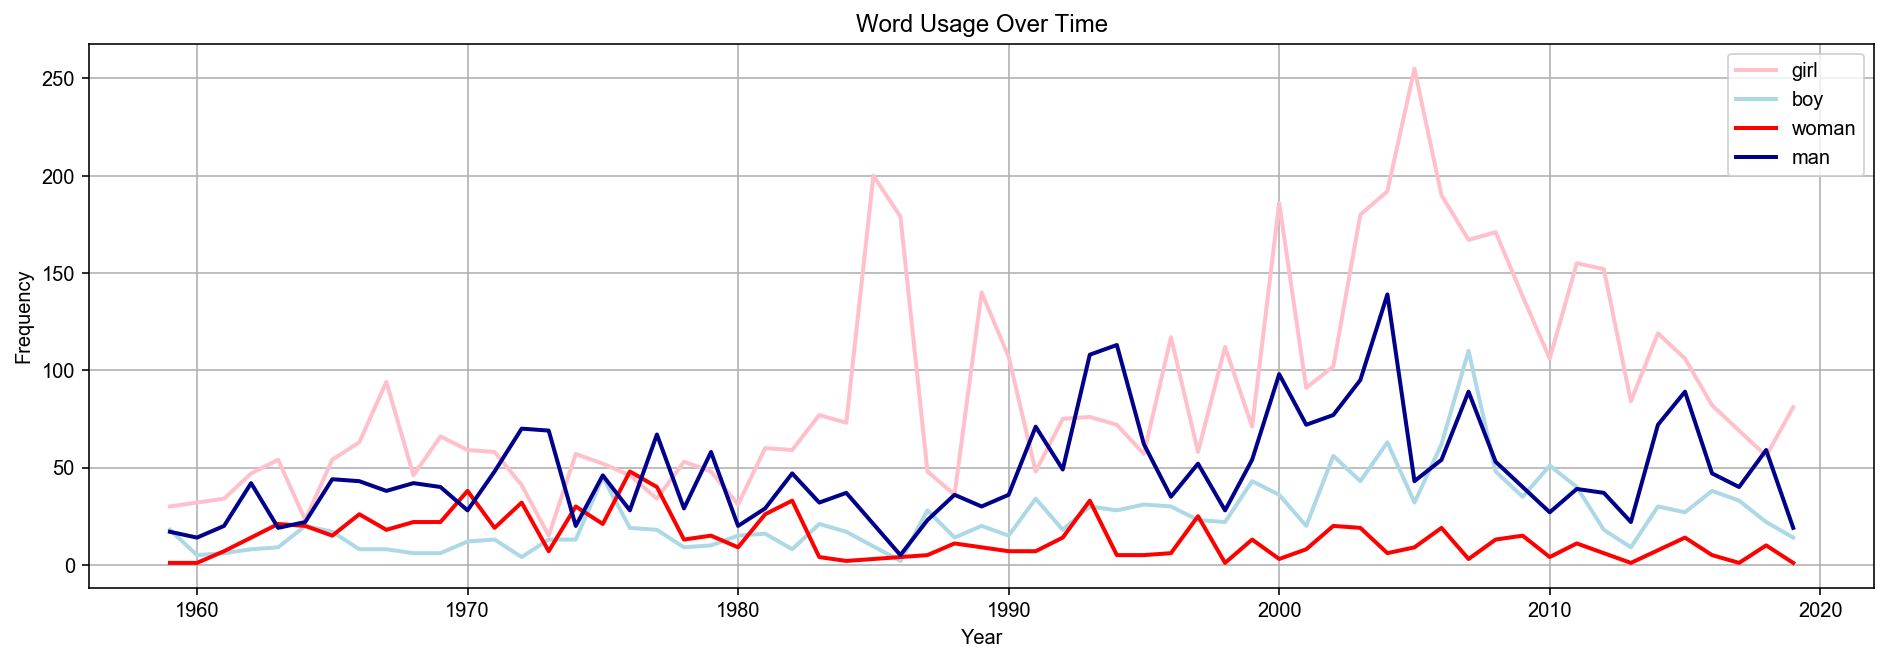

In [19]:
word_time_series(words=['girl', 'boy', 'woman', 'man'],
                 colors = ['pink', 'lightblue', 'red', 'darkblue'])

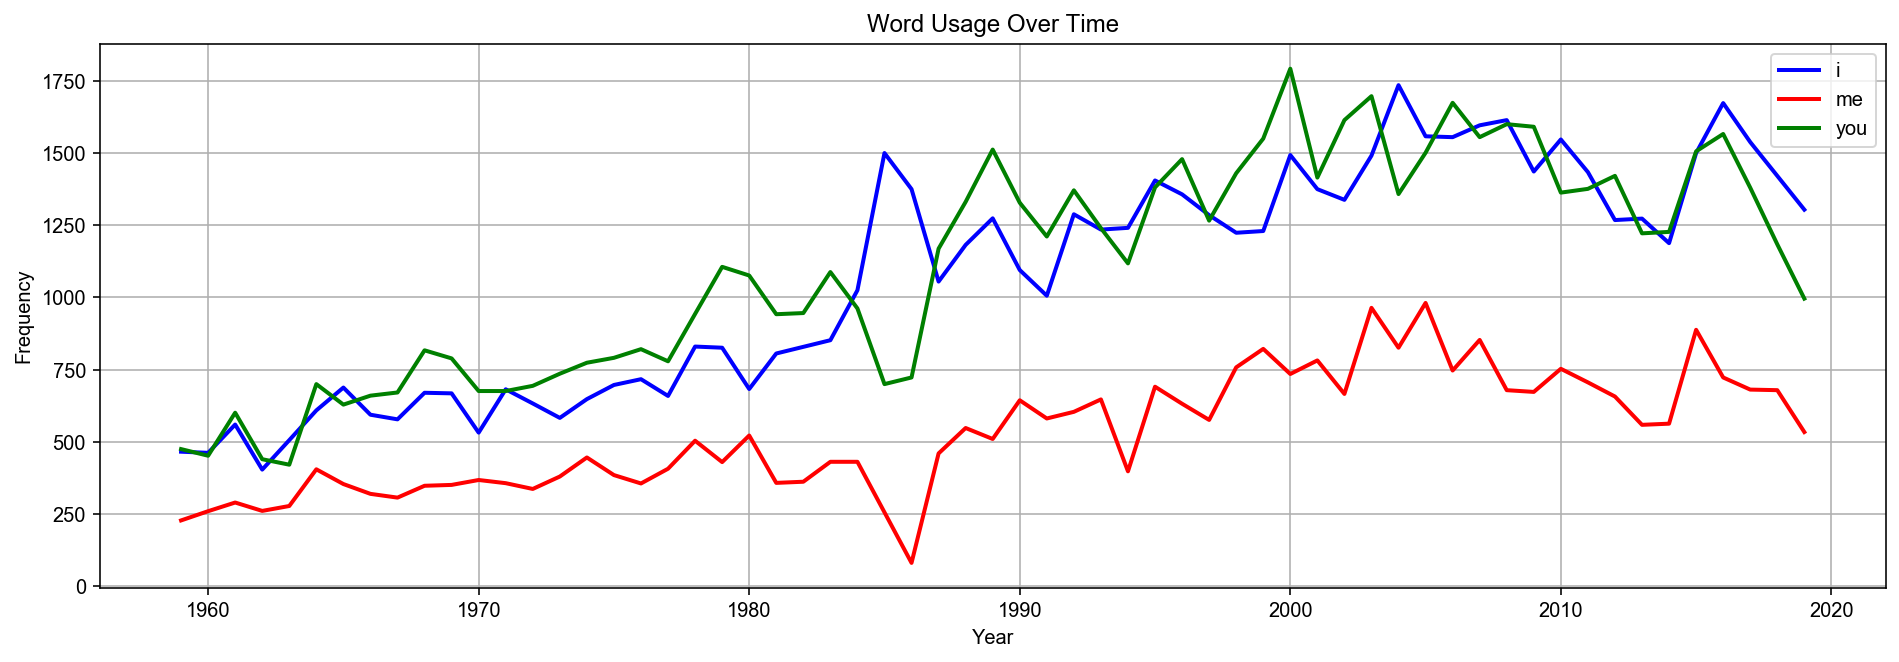

In [20]:
word_time_series(words=['i', 'me', 'you'],
                 colors=['blue', 'red', 'green'])

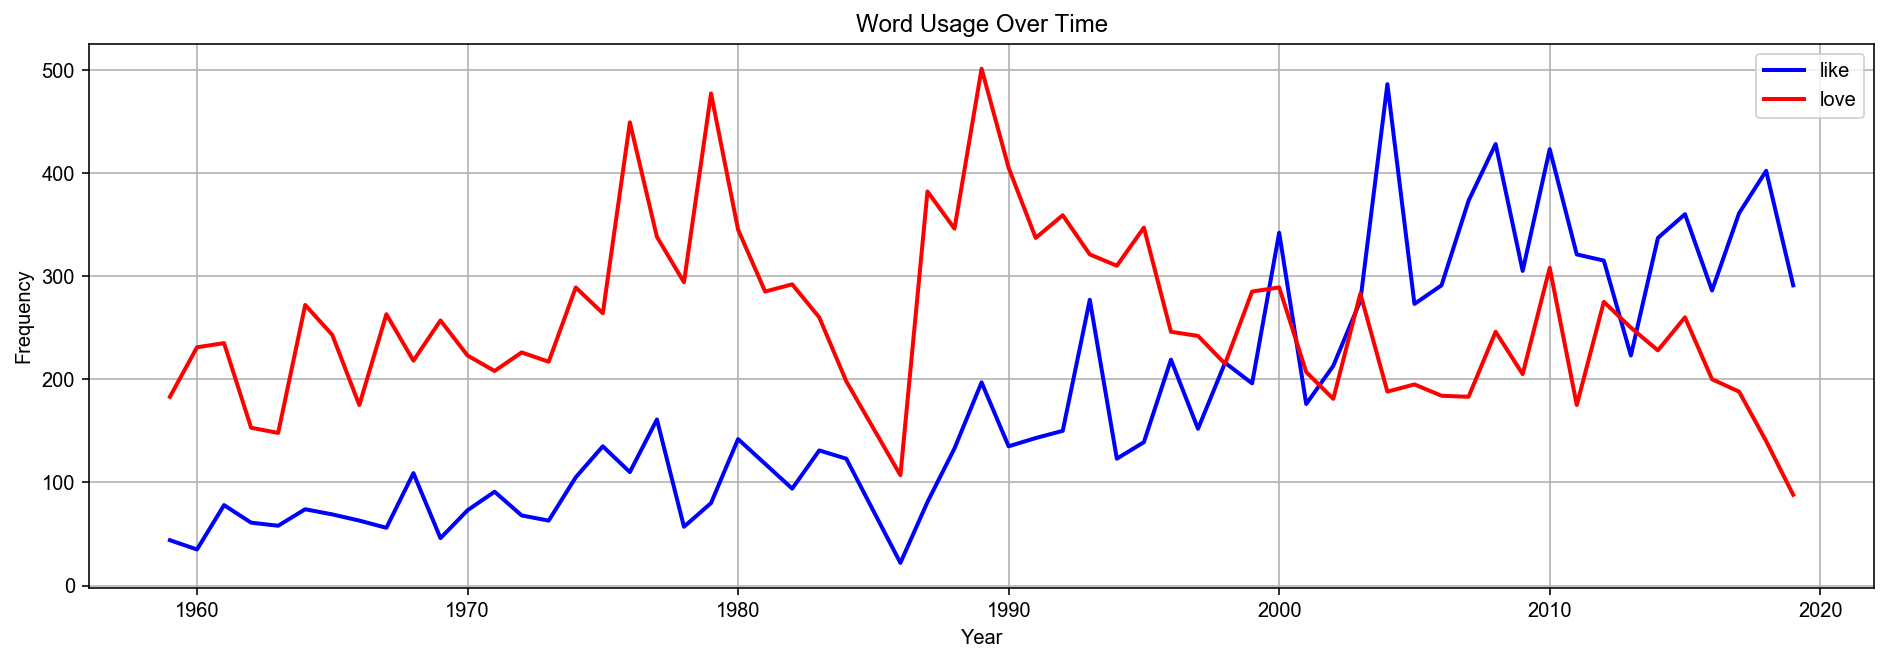

In [21]:
word_time_series(words=['like', 'love'],
                 colors = ['blue', 'red'])

## Latent space embeddings

In [22]:
df_nonnull = df[df['lyrics'].notnull()]
df_nonnull = df_nonnull.drop_duplicates(subset=['artist_clean', 'song_clean'], keep='first')

lyrics = df_nonnull['lyrics']
top_artists = df_nonnull.groupby('artist_clean')['song']\
                      .count()\
                      .sort_values(ascending=False)\
                      .index

X_entity_dfs = list()
count = CountVectorizer()
X_lyrics = count.fit_transform(lyrics)
X_lyrics = pd.DataFrame(X_lyrics.todense(), columns=count.get_feature_names())
X_songs = X_lyrics.set_index(df_nonnull['song'])
X_songs.index = [str('song_') + val for val in X_songs.index]
X_entity_dfs.append(X_songs)
X_songs_cp = X_songs.copy(deep=True)

artists = df_nonnull['artist_clean']
artists.index = X_songs_cp.index
X_songs_cp['artist_clean'] = artists
X_artists = X_songs_cp.groupby('artist_clean').mean()
X_artists = X_artists.reindex(top_artists).iloc[:20,:]
X_artists.index = [str('artist_') + val for val in X_artists.index]
X_entity_dfs.append(X_artists)

explicit = df_nonnull['explicit']
explicit.index = X_songs_cp.index
X_songs_cp['explicit'] = explicit
X_explicit = X_songs_cp.groupby('explicit').mean()
X_explicit.index = ['explicit_0', 'explicit_1']
X_entity_dfs.append(X_explicit)

decade = df_nonnull['decade']
decade.index = X_songs_cp.index
X_songs_cp['decade'] = decade
X_decade = X_songs_cp.groupby('decade').mean()
X_decade.index = ['decade_' + str(x) for x in range(1959, 2020, 10)]
X_entity_dfs.append(X_decade)

mode = df_nonnull['mode']
mode.index = X_songs_cp.index
X_songs_cp['mode'] = mode
X_mode = X_songs_cp.groupby('mode').mean()
X_mode.index = ['mode_0', 'mode_1']
X_entity_dfs.append(X_mode)

entities_index = list()
for X_entity_df in X_entity_dfs:
    entities_index.extend(list(X_entity_df.index))

X_entities = pd.concat(X_entity_dfs, axis='rows')
X_entities.index = entities_index

In [23]:
X_drop = X_entities.drop(['explicit', 'mode', 'decade'], axis='columns')

lda = LatentDirichletAllocation(n_components=10)
X_lda = lda.fit_transform(X_drop)

tsne = TSNE(n_components=2, metric='cosine', perplexity=75)
X_tsne = tsne.fit_transform(X_lda)

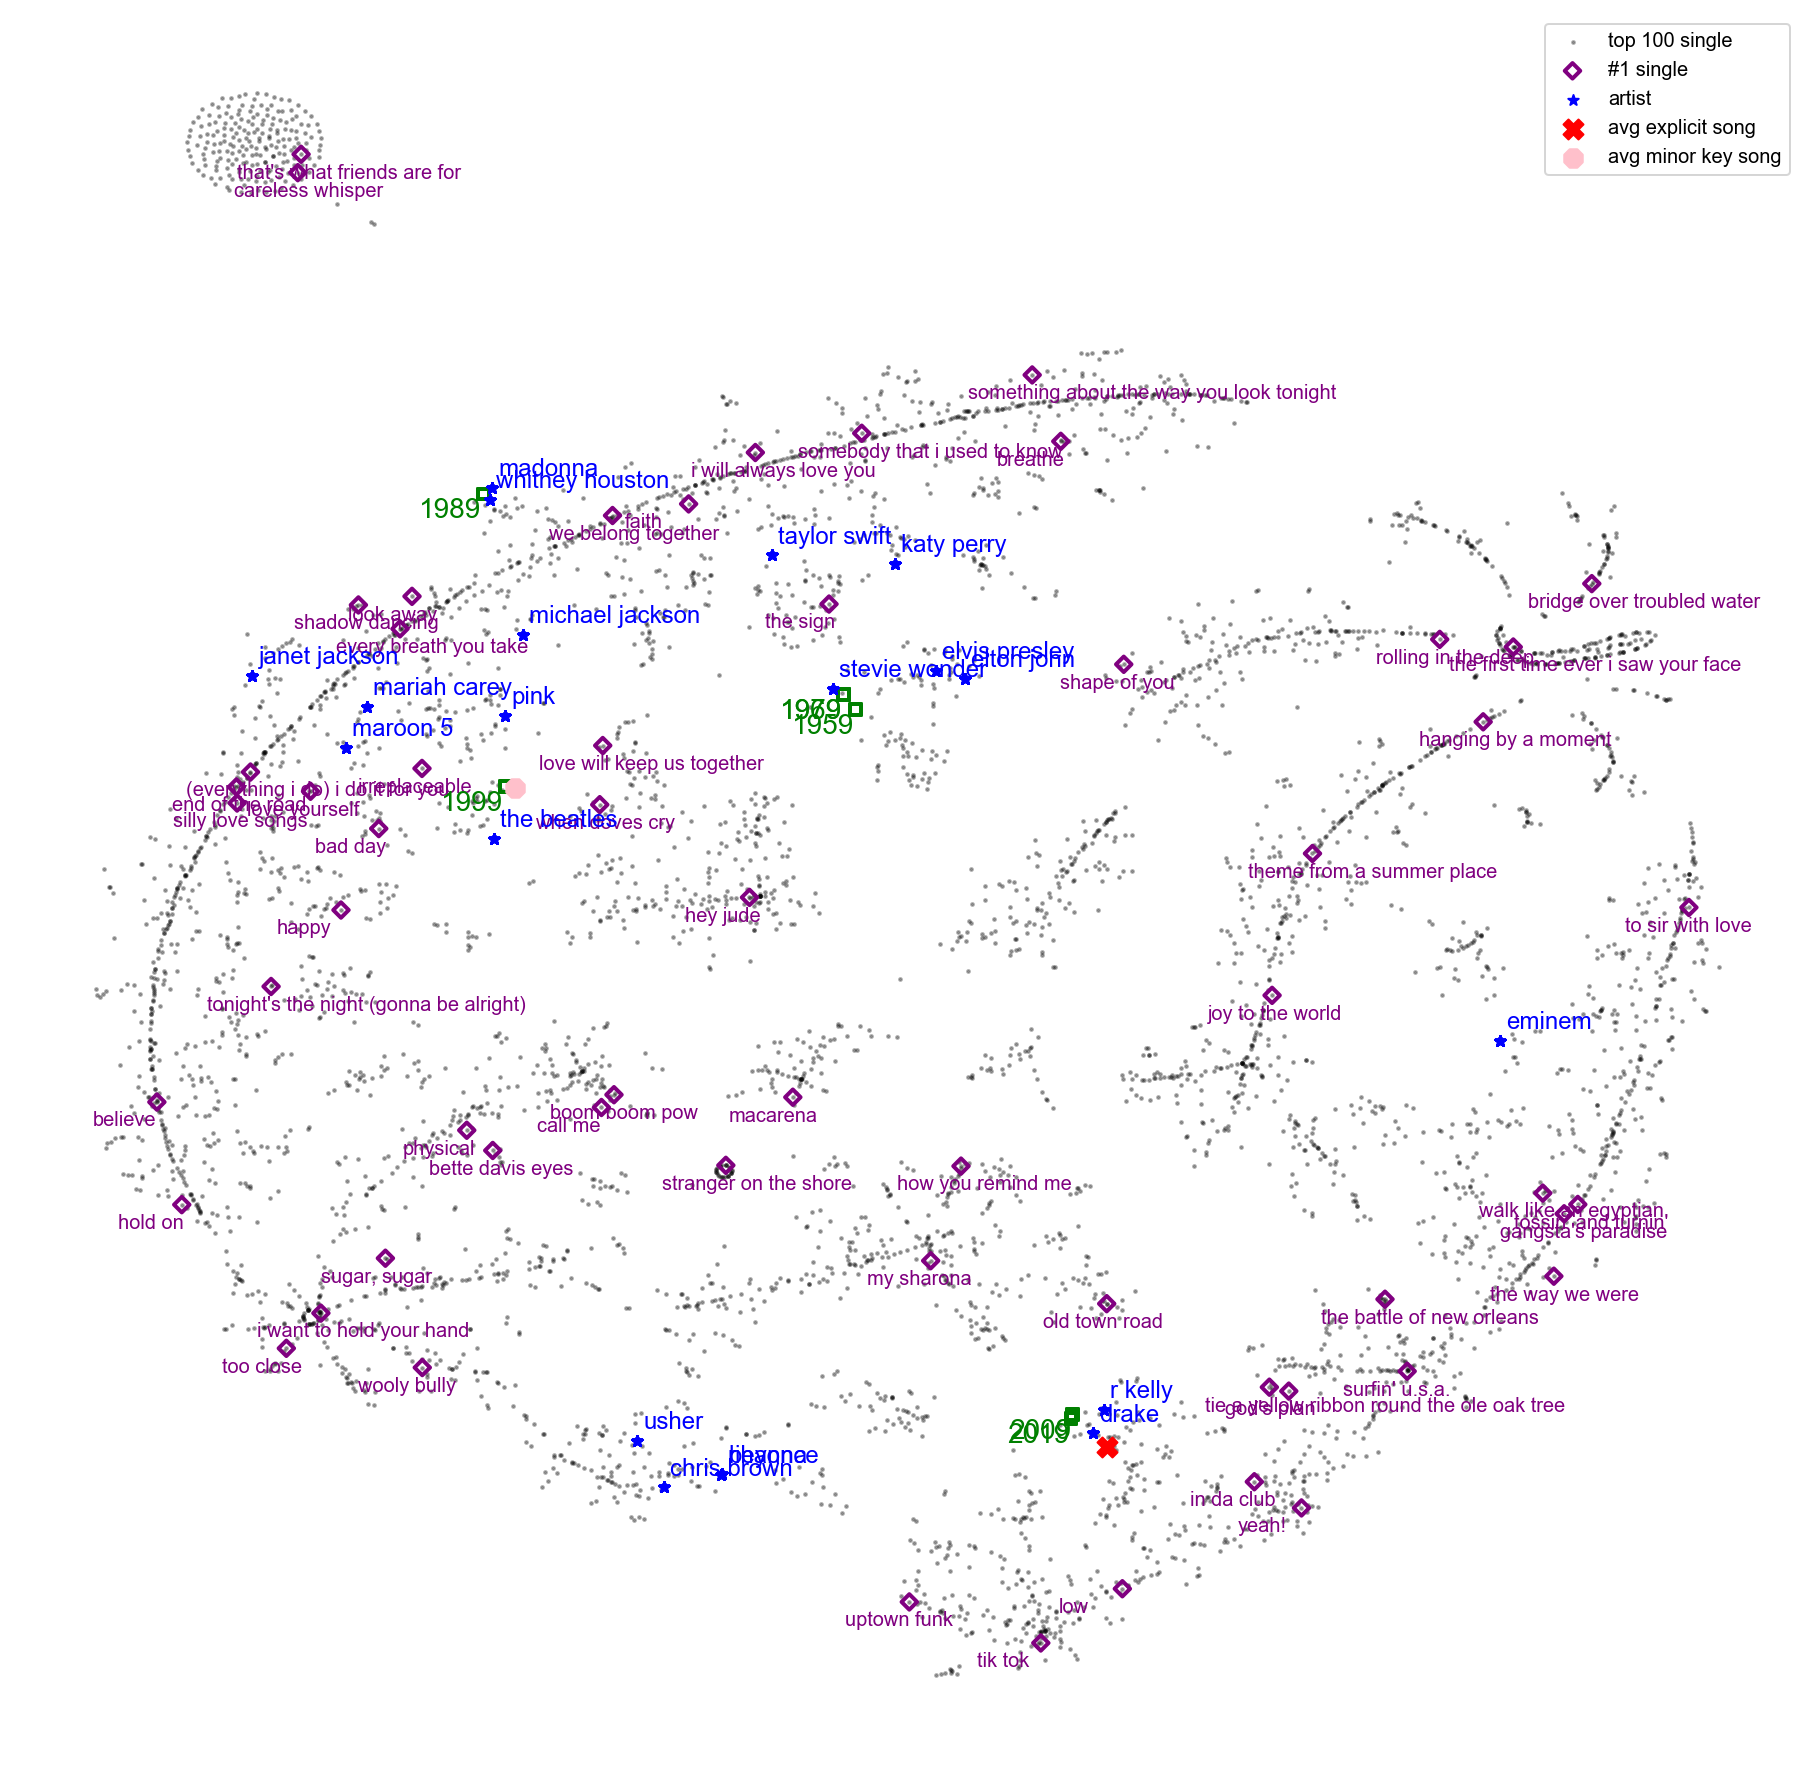

In [24]:
plt.figure(figsize=(16,16))
ax = plt.gca()

song_mask = X_entities.index.str.startswith('song_')
X_tsne_songs = X_tsne[song_mask,:]
ax.scatter(X_tsne_songs[:,0], X_tsne_songs[:,1], s=2, color='black', alpha=0.3,
           label='top 100 single', edgecolor='black', linewidth=1)

top_single_mask = df_nonnull['rank'] == 1
top_singles = df_nonnull.loc[top_single_mask, :]['song'].values
X_tsne_top = X_tsne[song_mask,:][top_single_mask,:]
for i in range(X_tsne_top.shape[0]):
    label = None
    if i == len(X_tsne_top) - 1:
        label = '#1 single'
    ax.annotate(top_singles[i], xy=X_tsne_top[i,:], color='purple',
                textcoords='offset points', xytext=(-32,-12), fontsize=10)
    ax.scatter(X_tsne_top[i,0], X_tsne_top[i,1], marker='D', color='None',
               linewidth=2, edgecolor='purple', s=30, label=label)

decade_mask = X_entities.index.str.startswith('decade_')
X_tsne_decade = X_tsne[decade_mask,:]
for i in range(X_tsne_decade.shape[0]):
    decade = X_entities.iloc[decade_mask,:].index[i][7:]
    label = None
    if decade == '2010':
        label = 'decade'
    ax.annotate(decade, xy=X_tsne_decade[i,:], color='green',
                textcoords='offset points', xytext=(-32,-12), fontsize=14)
    ax.scatter(X_tsne_decade[:,0], X_tsne_decade[:,1], marker='s', s=30,
               linewidth=2, alpha=0.5, edgecolor='green', color='None',
               label=label)
    
artists_mask = X_entities.index.str.startswith('artist_')
X_tsne_artists = X_tsne[artists_mask,:]
for i in range(X_tsne_artists.shape[0]):
    artist = X_artists.index[i][7:]
    label = None
    if i == len(X_tsne_artists) - 1:
        label = 'artist'
    ax.annotate(artist, xy=X_tsne_artists[i,:], color='blue',
                textcoords='offset points', xytext=(3,6), fontsize=12)
    ax.scatter(X_tsne_artists[:,0], X_tsne_artists[:,1], marker='*', s=30,
               linewidth=1, color='blue', label=label)
    
explicit_mask = X_entities.index == 'explicit_1'    
x,y = X_tsne[explicit_mask,:].squeeze()
ax.scatter(x, y, marker='X', s=100, linewidth=1, alpha=1, color='red',
           label='avg explicit song')

minor_mask = X_entities.index == 'mode_0'    
x,y = X_tsne[minor_mask,:].squeeze()
ax.scatter(x, y, marker='8', s=100, linewidth=1, alpha=1, color='pink',
           label='avg minor key song')

ax.legend()

#ax.set(xlim=(-35,35), ylim=(-100,100))
ax.axis('off');